In [13]:
# %%
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.visuals import *
import pickle

# ***** Define stellar properties *****#
R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-76b"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

from POSEIDON.core import define_model

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe", "Na", "Ca+", "Cr"]  # H2O, CO as in Brogi & Line

method = "sysrem"
# high_res_params = ['a', 'b', 'dPhi', 'K_p', 'V_sys', 'W_conv']
high_res_params = ["K_p", "V_sys", "W_conv", "log_a"]

model_1 = define_model(
    "Fe Na Ca+ Cr isotherm deck",
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
    high_res_params=high_res_params,
    reference_parameter="R_p_ref",
)


model_2 = define_model(
    "Fe Na Ca+ Cr isotherm deck a=0.1-5",
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
    high_res_params=high_res_params,
    reference_parameter="R_p_ref",
)

Generating corner plot 0...
Generating corner plot 1...


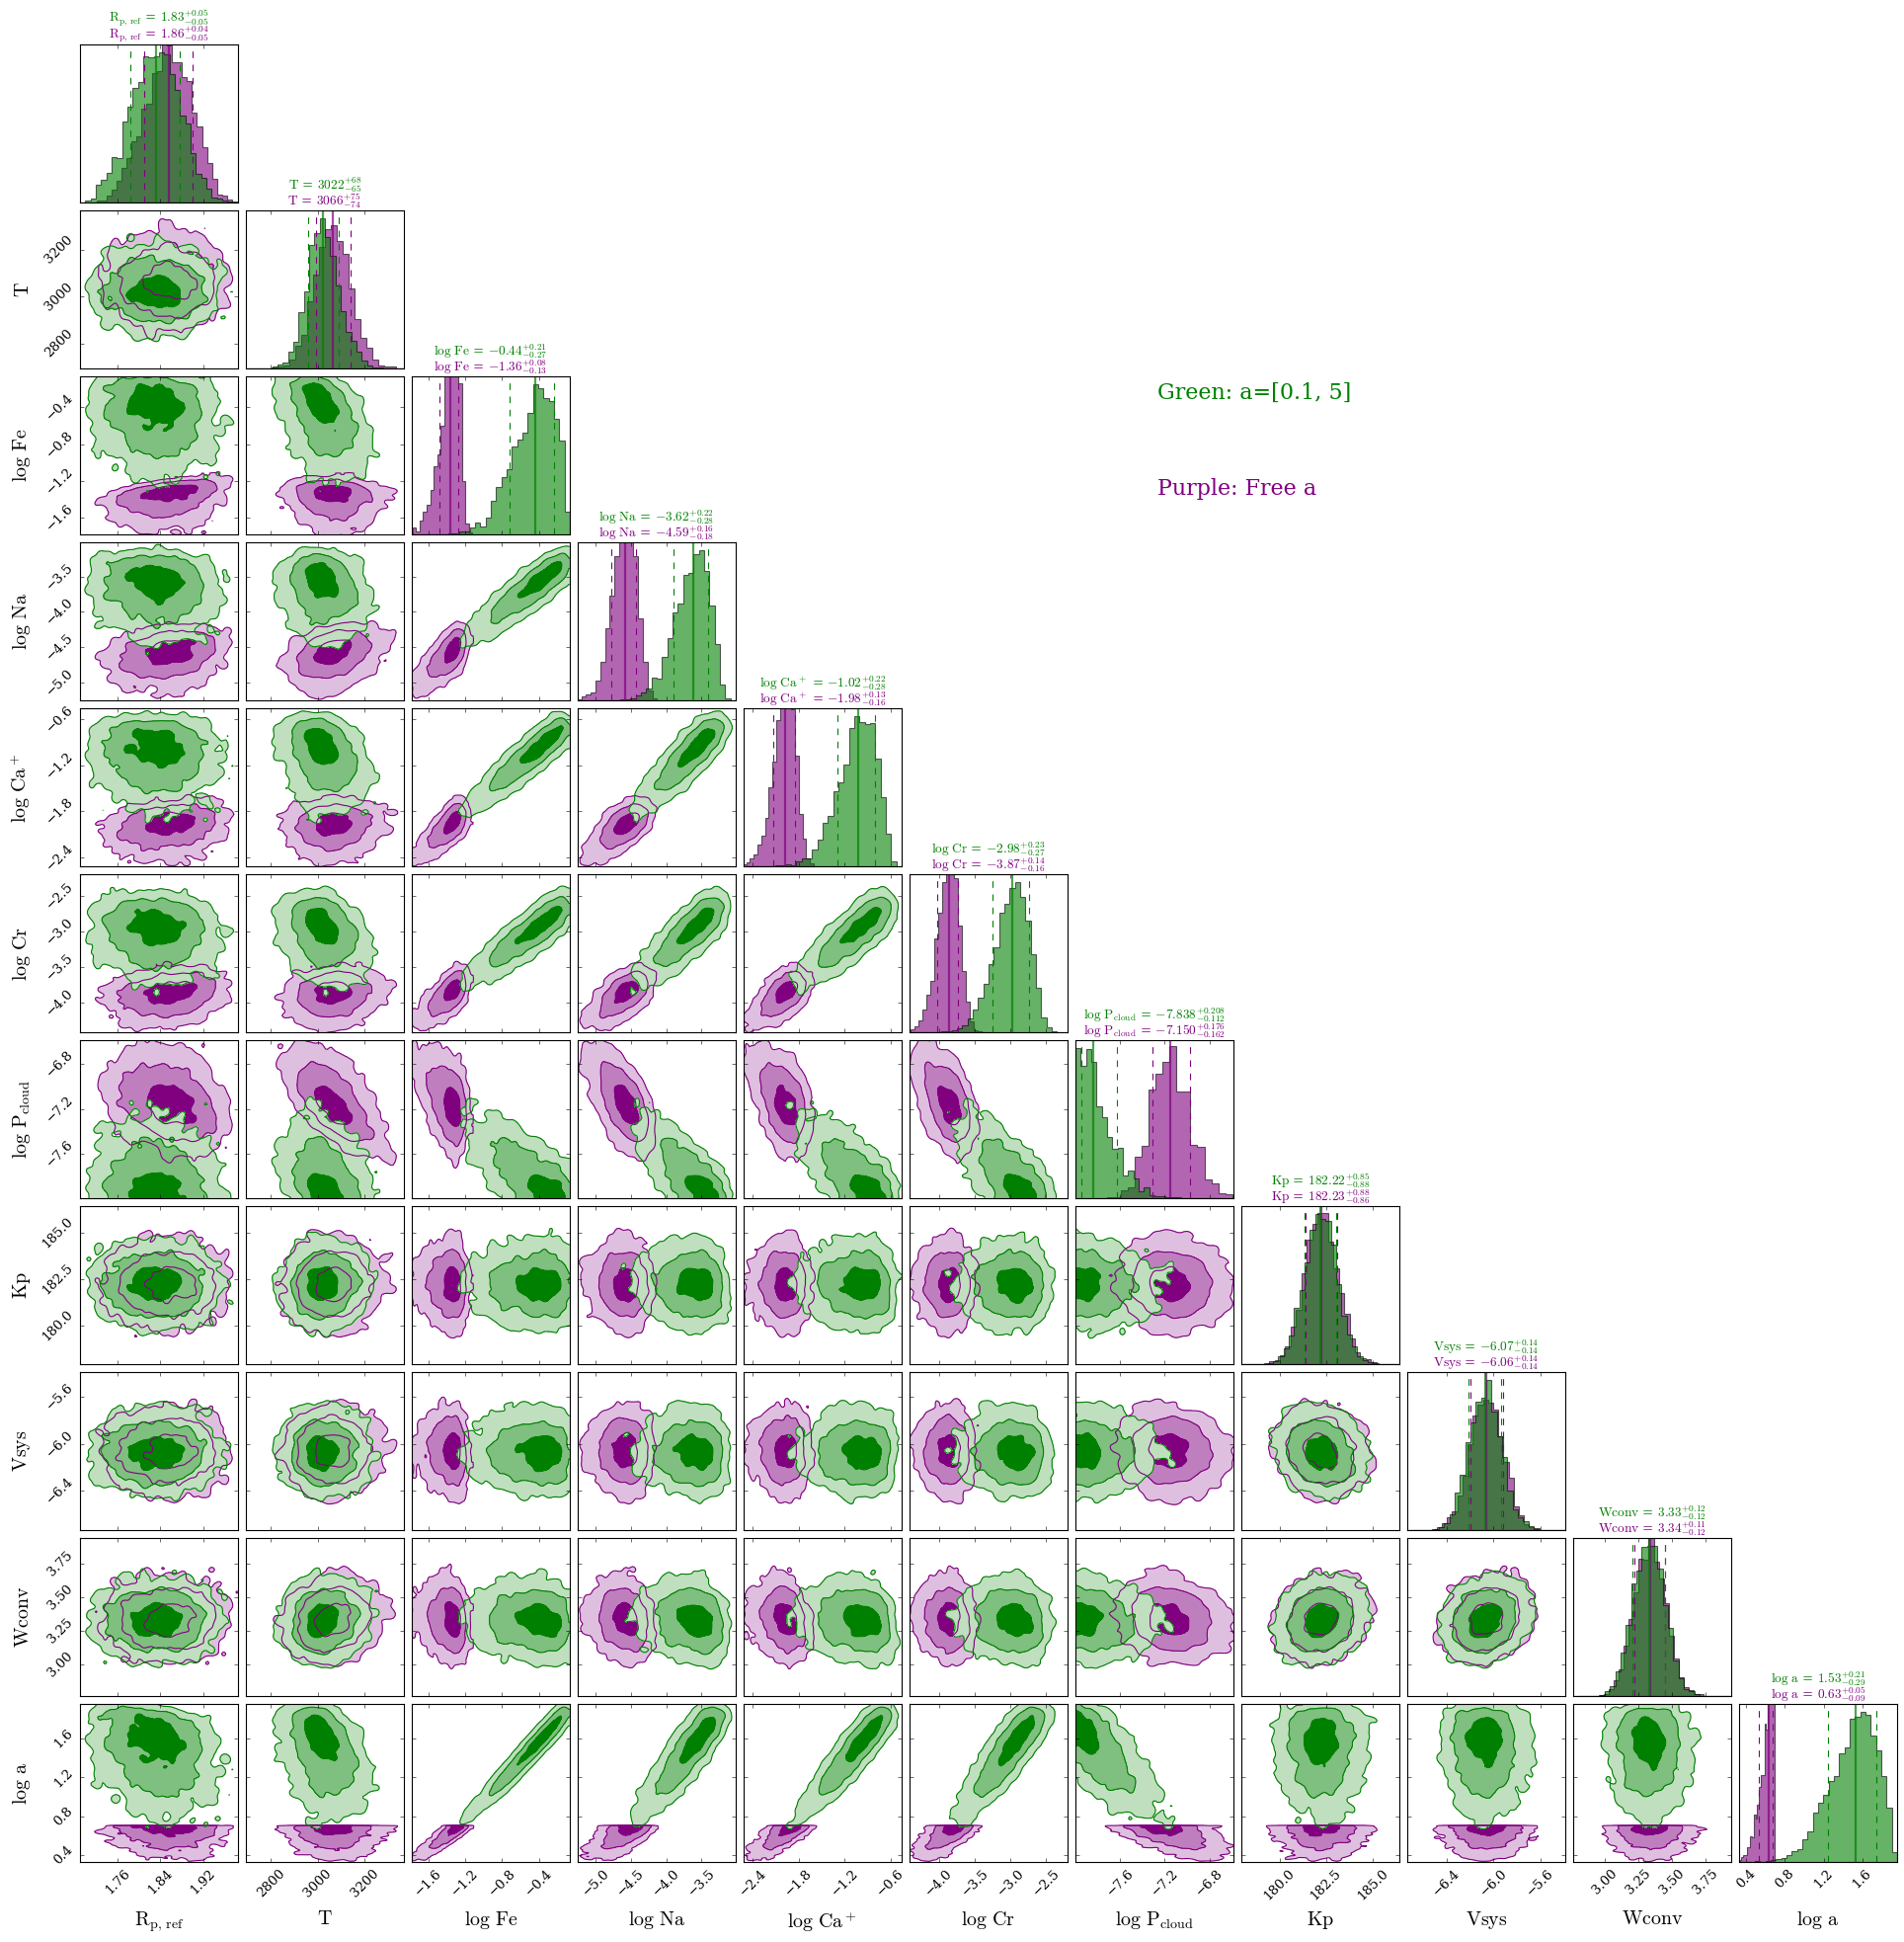

In [17]:
from POSEIDON.corner import generate_cornerplot, generate_overplot
import matplotlib.pyplot as plt

params_to_plot = [
    "R_p_ref",
    "T",
    "log_Fe",
    "log_Na",
    "log_Ca+",
    "log_Cr",
    "log_P_cloud",
    "K_p",
    "V_sys",
    "W_conv",
    "log_a",
]
fig = generate_overplot(
    planet,
    [model_2, model_1],
    params_to_plot=params_to_plot,
    model_display_names=["Free a", "a=[0.1, 5]"],
    # true_vals=[-4, -4, 192.6, -6.8],
    truth_colour="red",
    colour_schemes=["purple", "green"],
)

Generating corner plot ...


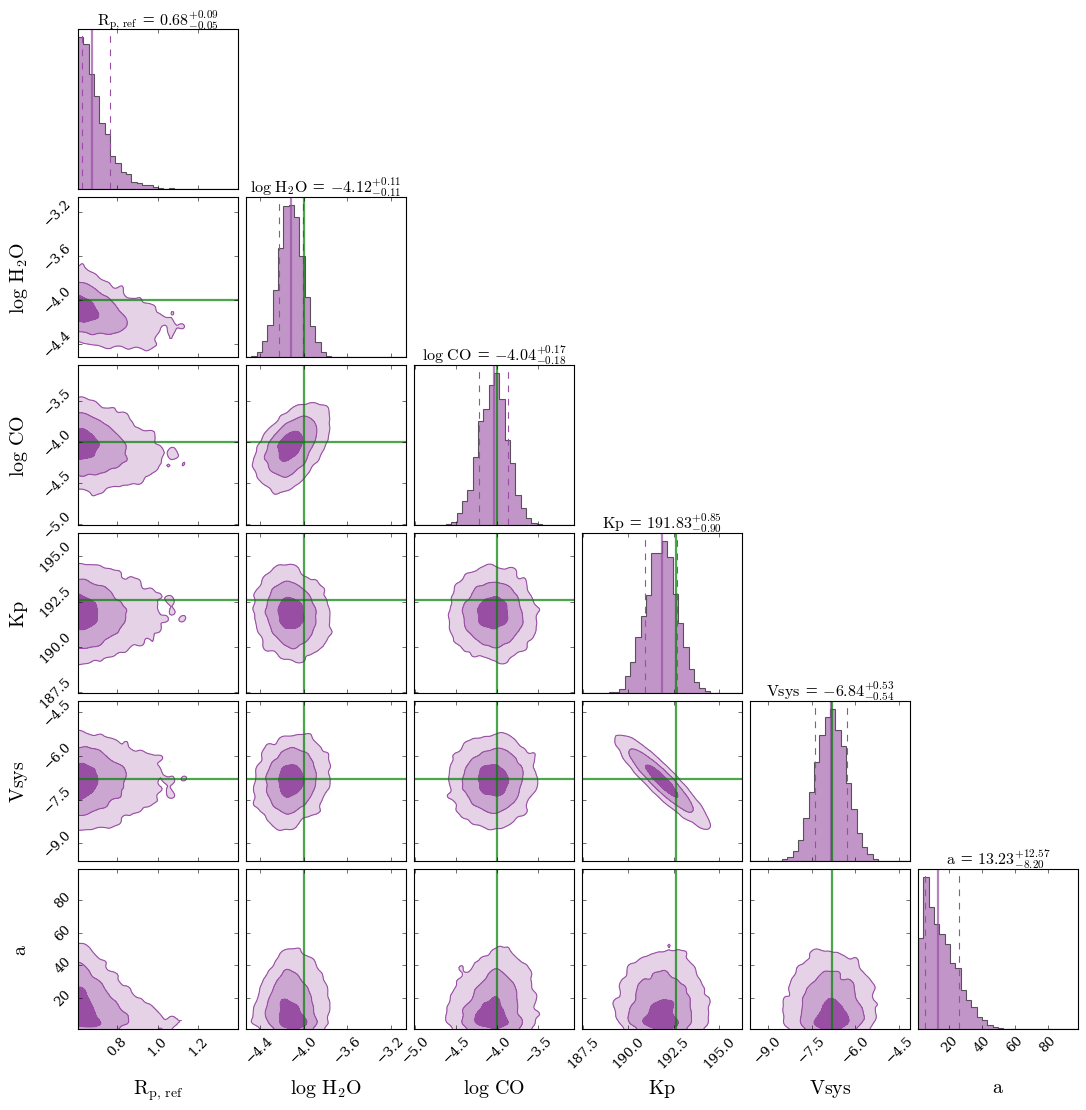

In [5]:
params_to_plot = ["R_p_ref", "log_H2O", "log_CO", "K_p", "V_sys", "a"]
fig = generate_cornerplot(
    planet,
    model_1,
    params_to_plot=params_to_plot,
    true_vals=[None, -4, -4, 192.6, -6.8, None],
)